In [1]:
import argparse
import torch
# import lib
import numpy as np
import os
import datetime
from loss import *
from network import *
from optimizer import *
from trainer import *
from torch.utils import data
import pickle
import sys
from dataset_time import *
# from data_time import *
from logger import *
import collections

import sys
sys.path.insert(0, '../PyTorch_GBW_LM')
sys.path.insert(0, '../PyTorch_GBW_LM/log_uniform')

from sampledSoftmax import *

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--hidden_size', default=50, type=int)
parser.add_argument('--num_layers', default=1, type=int)
parser.add_argument('--batch_size', default=100, type=int)
parser.add_argument('--dropout_input', default=0, type=float)
parser.add_argument('--dropout_hidden', default=.2, type=float)

# parse the optimizer arguments
parser.add_argument('--optimizer_type', default='Adagrad', type=str)
parser.add_argument('--final_act', default='tanh', type=str)
parser.add_argument('--lr', default=.05, type=float)
parser.add_argument('--weight_decay', default=0.0, type=float)
parser.add_argument('--momentum', default=0.1, type=float)
parser.add_argument('--eps', default=1e-6, type=float)

parser.add_argument("-seed", type=int, default=7,
					 help="Seed for random initialization")
parser.add_argument("-sigma", type=float, default=None,
					 help="init weight -1: range [-sigma, sigma], -2: range [0, sigma]")
parser.add_argument("--embedding_dim", type=int, default=-1,
					 help="using embedding")
# parse the loss type
parser.add_argument('--loss_type', default='TOP1', type=str)
# parser.add_argument('--loss_type', default='BPR', type=str)
parser.add_argument('--topk', default=5, type=int)
# etc
parser.add_argument('--bptt', default=1, type=int)
parser.add_argument('--test_observed', default=5, type=int)
parser.add_argument('--window_size', default=30, type=int)
parser.add_argument('--warm_start', default=5, type=int)

parser.add_argument('--n_epochs', default=20, type=int)
parser.add_argument('--time_sort', default=False, type=bool)
parser.add_argument('--model_name', default='GRU4REC', type=str)
parser.add_argument('--save_dir', default='models', type=str)
parser.add_argument('--data_folder', default='../Data/movielen/1m/', type=str)
parser.add_argument('--data_action', default='item.pickle', type=str)
parser.add_argument('--data_cate', default='cate.pickle', type=str)
parser.add_argument('--data_time', default='time.pickle', type=str)
parser.add_argument("--is_eval", action='store_true')
parser.add_argument('--load_model', default=None,  type=str)
parser.add_argument('--checkpoint_dir', type=str, default='checkpoint')
parser.add_argument('--data_name', default=None, type=str)
parser.add_argument('--shared_embedding', default=None, type=int)
parser.add_argument('--patience', default=1000)
parser.add_argument('--negative_num', default=1000, type=int)

# Get the arguments
args = parser.parse_args(args=[])
args.cuda = torch.cuda.is_available()


In [3]:
args.data_folder = "../Data/tmall/100k_unknown_cate/"
args.data_action = "item_time.pickle"
args.data_cate = "cate_time.pickle"
args.data_time = "time_time.pickle"
args.data_name = "taobao"
args.valid_start_time = 1512172800
valid_start_time = args.valid_start_time
args.test_start_time = 1512259200
test_start_time = args.test_start_time

In [4]:
args.embedding_dim = 300
args.hidden_size = 300
args.lr = 0.0001
args.window_size = 20
args.test_observed = 5
args.n_epochs = 300
args.shared_embedding = 1
args.batch_size = 300
args.optimizer_type = "Adam"

In [18]:
data_file = "data.pickle"
f = open(data_file, "rb")
data_map = pickle.load(f)
data_obj = data_map["data"]

In [5]:
hidden_size = args.hidden_size
num_layers = args.num_layers
batch_size = args.batch_size
dropout_input = args.dropout_input
dropout_hidden = args.dropout_hidden
embedding_dim = args.embedding_dim
final_act = args.final_act
loss_type = args.loss_type
topk = args.topk
optimizer_type = args.optimizer_type
lr = args.lr
weight_decay = args.weight_decay
momentum = args.momentum
eps = args.eps
BPTT = args.bptt

n_epochs = args.n_epochs
time_sort = args.time_sort

window_size = args.window_size
shared_embedding = args.shared_embedding

if embedding_dim == -1:
    print("embedding dim not -1", embedding_dim)
    raise AssertionError()

observed_threshold = args.test_observed

data_action = args.data_folder+args.data_action
data_cate = args.data_folder+args.data_cate
data_time = args.data_folder+args.data_time

data_obj = MYDATA(data_action, data_cate, data_time, valid_start_time, test_start_time, observed_threshold, window_size)

train_data = data_obj.train_dataset

print("+"*10)
print("valid load")


action seq num 51275
time seq num 51275
loading item map
loading item map
observed_threshold 5 20
loading data
valid_start_time 1512172800
test start time 1512259200
seq num for training 2738883
seq num of actions for training 2738883
seq num for testing 430797
seq num of actions for testing 430797
++++++++++
valid load


In [6]:
valid_data = data_obj.test_dataset
test_data = data_obj.test_dataset

input_size = data_obj.items()
output_size = input_size

negative_num = args.negative_num
# print("input_size", input_size)

train_data_loader = dataset.DataLoader(train_data, batch_size)

valid_data_loader = dataset.DataLoader(valid_data, batch_size)

data_name = args.data_name

item num 68008
seq num 2738883
batch size 300
batch_num 9129
seq num 430797
batch size 300
batch_num 1435


In [7]:
input_size

68008

In [8]:
ss = SampledSoftmax(output_size, negative_num, embedding_dim, None)

log = Logger()
log.addIOWriter(args)

model = GRU4REC(log, ss, input_size, hidden_size, output_size,
                    final_act=final_act,
                    num_layers=num_layers,
                    use_cuda=args.cuda,
                    dropout_input=dropout_input,
                    dropout_hidden=dropout_hidden,
                    embedding_dim=embedding_dim,
                    shared_embedding=shared_embedding
                    )

output_file hcdmg3_21_44_31_05_300_300_300_Adam_0.0001_20_1_taobao
self device cuda


/zf15/rc7ne/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


share embedding


In [9]:
save_path = "../log/samplePaddingSessionRNN/checkpoint/01180955/model_best.pt"

save_model_data = torch.load(save_path)
# print(save_model_data)
model.load_state_dict(save_model_data['model']) 
model.eval()

print(save_model_data['recall'])
print(save_model_data['mrr'])

0.18883391405342626
0.08396582052838511


In [25]:
recall = save_model_data['recall']
print("recall", recall)

mrr = save_model_data['mrr']
print("mrr", mrr)

recall 0.18883391405342626
mrr 0.08396582052838511


In [10]:
loss_type = "XE"
loss_func = LossFunction(loss_type=loss_type, use_cuda=args.cuda)

In [27]:
a = [1, 2, 3]
b = np.array([4, 5, 6])
c = a+list(b)
print(c)

[1, 2, 3, 4, 5, 6]


In [18]:
model.eval()
dataloader = valid_data_loader

losses = []
recalls = []
mrrs = []
weights = []

topk = 5
eval_iter = 0
device = torch.device('cuda')
warm_start = 5
# warm_start = args.warm_start

idx_list = []

with torch.no_grad():
    total_test_num = []

    for x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch, y_action_batch, y_action_idx_batch in dataloader:
            
#         idx_list += list(y_action_idx_batch)
        
        x_short_action_batch = x_short_action_batch.to(device)
        mask_short_action_batch = mask_short_action_batch.to(device)
        y_action_batch = y_action_batch.to(device)

        warm_start_mask = (y_action_idx_batch >= warm_start)
        if torch.sum(warm_start_mask).item() == 0:
            continue

        output_batch = model(x_short_action_batch, mask_short_action_batch, pad_x_short_actionNum_batch)

        # et_1 = datetime.datetime.now()
        # print("duration 1", et_1-st)

        sampled_logit_batch, sampled_target_batch = model.m_ss(output_batch, y_action_batch, None, None, None, None, None, None, "full")

        loss_batch = loss_func(sampled_logit_batch, sampled_target_batch)
        losses.append(loss_batch.item())

        # et_2 = datetime.datetime.now()
        # print("duration 2", et_2-et_1)

        # logit_batch = self.model.m_ss.params(output_batch)
        recall_batch, mrr_batch = evaluate(sampled_logit_batch, sampled_target_batch, warm_start_mask, k=topk)

        weights.append( int( warm_start_mask.int().sum() ) )
        recalls.append(recall_batch)
        mrrs.append(mrr_batch)

        # et_3 = datetime.datetime.now()
        # print("duration 3", et_3-et_2)

        total_test_num.append(int( warm_start_mask.int().sum() ))

    mean_losses = np.mean(losses)
    mean_recall = np.average(recalls, weights = weights)
    mean_mrr = np.average(mrrs, weights = weights)
          
print("total_test_num", np.sum(total_test_num))
print("recall", mean_recall)
print("mrr", mean_mrr)

shuffling
total_test_num 430500
recall 0.12294541231126598
mrr 0.07740027521856986


In [ ]:
shuffling
total_test_num 305021
recall 0.2941948462184953
mrr 0.08563804351286605

In [ ]:
total_test_num 127796
recall 0.2987652195686876
mrr 0.08026587741838981

In [ ]:
recall 0.28708706476905355
mrr 0.08779376165564898

In [ ]:
total_test_num 35540
recall 0.2579628587507034
mrr 0.08437233997105033

In [ ]:
total_test_num 48494
recall 0.29376830123314224
mrr 0.07904030092175612

In [19]:
len(idx_list)

430500

In [20]:
import seaborn as sns

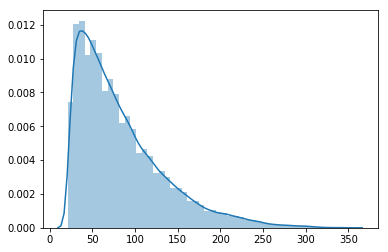

In [21]:
sns.distplot(idx_list)

In [ ]:
shuffling
total_test_num 430500
recall 0.2987652195686876
mrr 0.08026587741838981

In [13]:
model.eval()
dataloader = valid_data_loader

losses = []
recalls = []
mrrs = []
weights = []

nonzero_cate_num_total = 0

topk = 5
eval_iter = 0
device = torch.device('cuda')
warm_start = args.warm_start
with torch.no_grad():
    total_test_num = []

    for x_cate_batch, mask_cate, max_acticonNum_cate, seqLen_cate, x_batch, mask_batch, seqLen_batch, y_batch, idx_batch in dataloader:        
        x_cate_batch = x_cate_batch.to(device)
        mask_cate = mask_cate.to(device)
        
        x_batch = x_batch.to(device)
        mask_batch = mask_batch.to(device)

        y_batch = y_batch.to(device)
        warm_start_mask = (idx_batch>=warm_start).to(device)
        
        nonzero_cate_num = np.count_nonzero(seqLen_cate)
        nonzero_cate_num_total += nonzero_cate_num
#         print("zero_cate_num", zero_cate_num)
#         print("seqLen_cate", seqLen_cate)
#         print(seqLen_cate.nonzero())

#         exit()
print("nonzero_cate_num_total", nonzero_cate_num_total)


batch_num 4158
zero_cate_num_total 634331


In [14]:
634331.0/831600

0.7627837902837903

In [4]:
np.count_nonzero(np.eye(4))

4